# STM Transit Delay Data Preprocessing

## Overview

This notebook preprocesses data about STM trip updates weather and traffic, data in order to build a regression and classification model that predicts delays in seconds.

## Data Description

`trip_id`: Unique identifier for the transit trip.<br>
`vehicle_id`: Unique identifier for a vehicle.<br>
`vehicle_bearing`: Direction that the vehicle is facing, from 0 to 360 degrees.<br>
`vehicle_speed`: Momentary speed measured by the vehicle, in meters per second.<br>
`vehicle_in_transit`: Indicates the vehicle stop status in relation with a stop that it's currently approaching or is at, 1 being "in transit" and 0 being "stopped".<br>
`occupancy_status`: Degree of passenger occupancy, from "Empty" to "Not accepting passengers".<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`route_type`: Type of bus line (e.g. Night).<br>
`stop_id`: Unique identifier of a stop.<br>
`stop_name`: Name of the stop.<br>
`stop_lat`, `stop_lon`: Stop coordinates.<br>
`stop_distance`: Distance between the previous and current stop, in meters.<br>
`stop_sequence`: Sequence of the stop, for ordering.<br>
`trip_progress`: How far along the trip is the vehicle, from 0 (first stop) to 1 (last stop).<br>
`stop_has_alert`: Indicates if there's a message about the stop being moved or cancelled.<br>
`schedule_relationship`: State of the schedule: "scheduled", "skipped" or "no data".
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair.<br>
`rt_arrival_time`, `rt_departure_time`, `sch_arrival_time`, `sch_departure_time`: Realtime and scheduled times, in UTC.<br>
`delay`: Difference between real and scheduled arrival time, in seconds<br>
`delay_class`: Delay category, from early to late<br>
`incident_count`: Number of incidents within 500 meters of the stop.<br>
`incident_nearby`: Indicates if an incident happened within 500 meters of the stop.<br>
`temperature`: Air temperature at 2 meters above ground, in Celsius.<br>
`relative_humidity`: Relative humidity at 2 meters above ground, in percentage.<br>
`dew_point`: Dew point temperature at 2 meters above ground, in Celsius.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`pressure`: Atmospheric air pressure reduced to mean sea level (msl), in hPa.<br>
`cloud_cover`: Total cloud cover as an area fraction.<br>
`windspeed`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`wind_direction`: Wind direction at 10 meters above ground.<br>
`wind_gusts`: Gusts at 10 meters above ground as a maximum of the preceding hour.<br>

## Imports

In [79]:
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import sys

In [6]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import DELAY_CLASS, LOCAL_TIMEZONE, OCCUPANCY_STATUS

In [30]:
# Load data
df = pd.read_parquet('../data/stm_weather_traffic_merged.parquet')
stops_df = pd.read_csv('../data/download/stops_2025-04-30.txt')

## Data Preprocessing

### Handle Delay Outliers

In [31]:
df['delay'].describe()

count    1.560534e+06
mean     6.523292e+01
std      3.701439e+02
min     -1.359200e+04
25%      0.000000e+00
50%      0.000000e+00
75%      1.100000e+01
max      5.458500e+04
Name: delay, dtype: float64

In [32]:
# Compute mean and standard deviation
mean_delay = df['delay'].mean()
std_delay = df['delay'].std()

In [33]:
# Filter outliers based on standard deviation
outlier_mask = (df['delay'] < mean_delay - 3 * std_delay) | (df['delay'] > mean_delay + 3 * std_delay)

In [34]:
# Get proportion of outliers
print(f'{outlier_mask.mean():.2%}')

0.72%


In [35]:
# Remove outliers
df = df[~outlier_mask].reset_index(drop=True)

In [36]:
# Get new distribution
df['delay'].describe()

count    1.549316e+06
mean     5.289960e+01
std      1.446920e+02
min     -1.043000e+03
25%      0.000000e+00
50%      0.000000e+00
75%      6.000000e+00
max      1.175000e+03
Name: delay, dtype: float64

### Encode Datetime

In [37]:
# Convert scheduled arrival time
df['sch_arrival_time'] = pd.to_datetime(df['sch_arrival_time'], utc=True).dt.tz_convert(LOCAL_TIMEZONE)

In [38]:
# Convert datetime to day and hour
df['day_of_week'] = df['sch_arrival_time'].dt.day_of_week
df['hour'] = df['sch_arrival_time'].dt.hour

In [39]:
# Convert hour to time of day
def time_of_day(hour):
  if 5 <= hour < 10:
    return 'morning'
  elif 10 <= hour < 15:
    return 'midday'
  elif 15 <= hour < 20:
    return 'evening'
  else:
    return 'night'

df['time_of_day'] = df['hour'].apply(time_of_day)
df['time_of_day'].value_counts()

time_of_day
evening    534898
midday     410107
morning    383848
night      220463
Name: count, dtype: int64

In [40]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['time_of_day'], drop_first=True, dtype='int64', prefix='time_of_day')
df = df.join(one_hot).drop('time_of_day', axis=1)

In [41]:
# Add boolean value is_weekend
weekend_mask = df['day_of_week'].isin([5, 6])
df['is_weekend'] = np.where(weekend_mask, 1, 0)

In [42]:
# Add boolean value is_peak_hour (weekdays from 7-9am or 4-6pm)
peak_hour_mask = (weekend_mask == False) & (df['hour'].isin([7, 8, 9, 16, 17, 18]))
df['is_peak_hour'] = np.where(peak_hour_mask, 1, 0)

In [43]:
# Drop unneeded time-related columns
df = df.drop(['rt_arrival_time', 'rt_departure_time', 'sch_arrival_time', 'sch_departure_time', 'hour'], axis=1)

### Use Ordinal Encoding for delay_class and occupancy_status

In [44]:
delay_map = {value: key for (key, value) in DELAY_CLASS.items()}
df['delay_class'] = df['delay_class'].map(delay_map).astype('int64')
df['delay_class'].value_counts(normalize=True)

delay_class
1    0.865317
2    0.118612
0    0.016071
Name: proportion, dtype: float64

In [45]:
occ_map = {value: key for (key, value) in OCCUPANCY_STATUS.items()}
df['occupancy_status'] = df['occupancy_status'].map(occ_map)
df['occupancy_status'].value_counts(normalize=True)

occupancy_status
1    0.448113
2    0.318042
3    0.217068
5    0.016047
0    0.000729
Name: proportion, dtype: float64

### Use One Hot Encoding for trip_progress, route_type and schedule_relationship

In [46]:
df['route_type'].value_counts()

route_type
Day                         869656
Rush Hour High Frequency    399268
All Day High Frequency      251228
Night                        29164
Name: count, dtype: int64

In [47]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['route_type'], drop_first=True, dtype='int64', prefix='route_type')
df = df.join(one_hot).drop('route_type', axis=1)

In [48]:
df['schedule_relationship'].value_counts()

schedule_relationship
Scheduled    1534861
Skipped         8214
No Data         6241
Name: count, dtype: int64

In [ ]:
# Collapse categories
df['schedule_relationship'] = np.where(df['schedule_relationship'] != 'Scheduled', 'Not Scheduled', df['schedule_relationship'])
df['schedule_relationship'].value_counts()

schedule_relationship
Scheduled        1534861
Not Scheduled      14455
Name: count, dtype: int64

In [50]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['schedule_relationship'], drop_first=True, dtype='int64', prefix='sch_rel')
df = df.join(one_hot).drop('schedule_relationship', axis=1)

In [51]:
# Create buckets for trip_progress
ranges = [0, 0.33, 0.66, 1.0]
labels = ['start', 'middle', 'end']

df['trip_phase'] = pd.cut(df['trip_progress'], bins=ranges, labels=labels, include_lowest=True, right=False)
df['trip_phase'].value_counts(normalize=True)

trip_phase
end       0.375091
middle    0.323677
start     0.301232
Name: proportion, dtype: float64

In [52]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['trip_phase'], drop_first=True, dtype='int64', prefix='trip_phase')
df = df.join(one_hot).drop(['trip_progress', 'trip_phase'], axis=1)

### Use K-Means to cluster stop locations

In [58]:
# Scale coordinates
coords_df = stops_df[['stop_lat', 'stop_lon']]
scaler_coords = StandardScaler()
coords_df_scaled = scaler_coords.fit_transform(coords_df)
coords_df_scaled = pd.DataFrame(coords_df_scaled, columns=scaler_coords.get_feature_names_out())
coords_df_scaled

,stop_lat,stop_lon
0,-1.224117,0.392250
1,-1.224117,0.392250
2,-1.226468,0.384756
3,-1.149054,0.495472
4,-1.149054,0.495472
...,...,...
8989,-1.434924,-2.783942
8990,-1.785955,-3.225377
8991,-1.907444,-3.130798
8992,1.397607,-0.224108


In [59]:
# Build multiple K-Means models
models = []
for k in range(2, 31):
	kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
	kmeans.fit(coords_df_scaled)
	labels = kmeans.labels_
	models.append({
		'k': k,
		'ssd': kmeans.inertia_,
		'silhouette': silhouette_score(coords_df_scaled, labels, metric='euclidean'),
	})

models_df = pd.DataFrame(models).set_index('k')

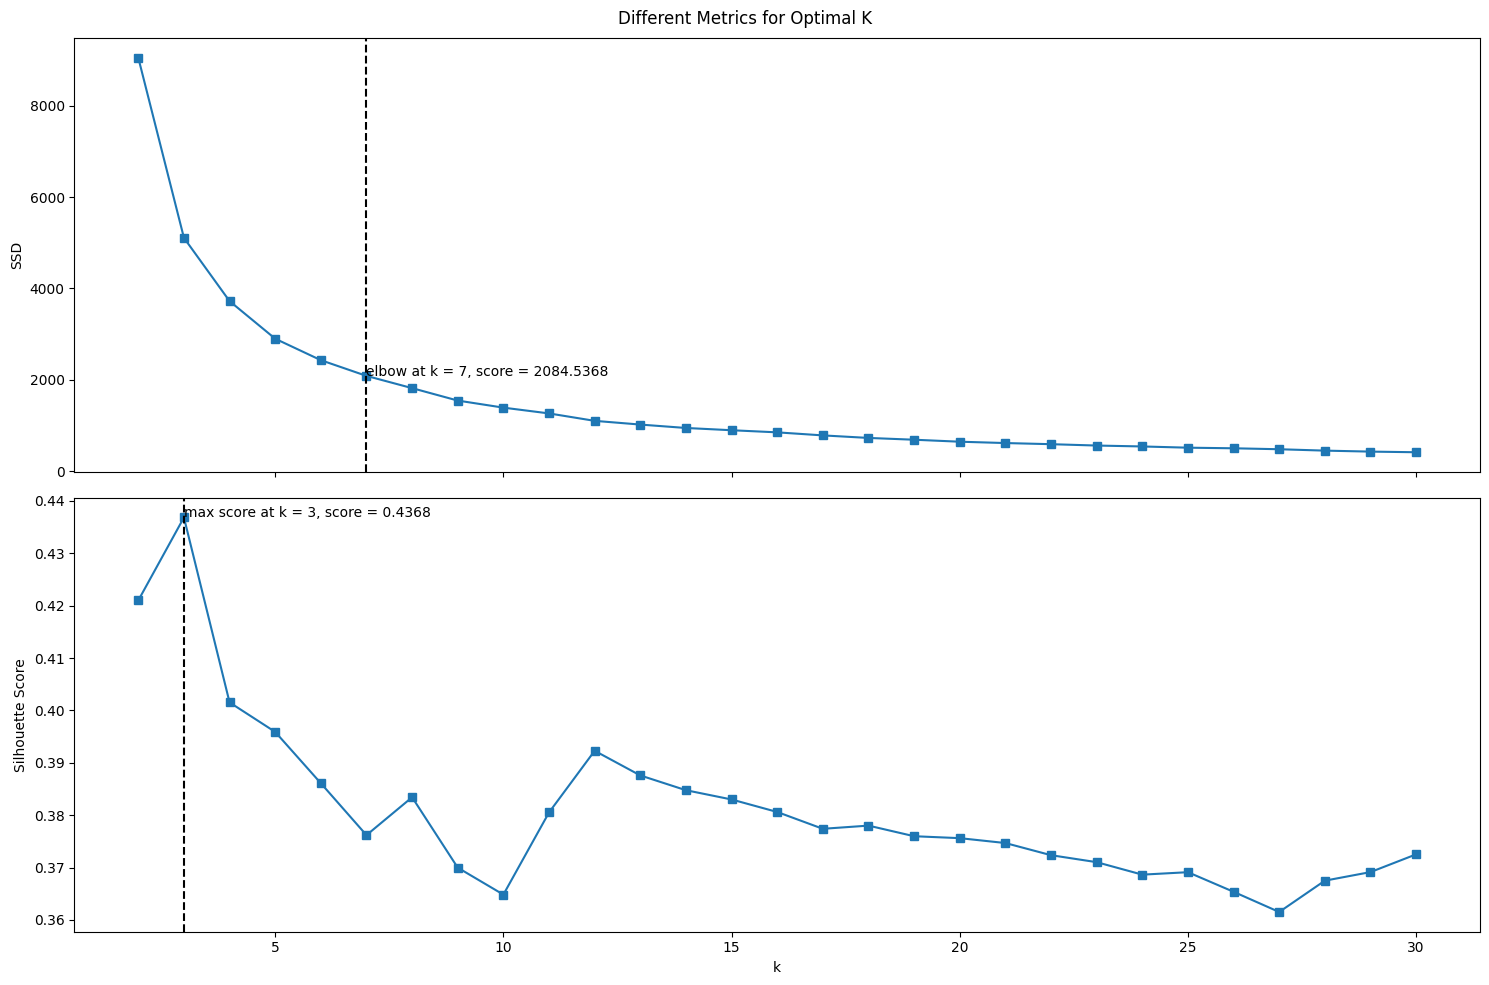

In [ ]:
# Display K plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,10), sharex=True)

# Elbow Method
kneedle = KneeLocator(models_df.index, models_df['ssd'], curve='convex', direction='decreasing')
optimal_k = kneedle.elbow
optimal_score = models_df.loc[optimal_k, 'ssd']
ax1.plot(models_df['ssd'], marker='s')
ax1.set_ylabel('SSD')
ax1.axvline(x=optimal_k, color='black', linestyle='--')
ax1.annotate(f'elbow at k = {optimal_k}, score = {round(optimal_score, 4)}', xy=(optimal_k, optimal_score))

# Silhouette Score
optimal_k = models_df['silhouette'].idxmax()
max_score = models_df['silhouette'].max()
ax2.plot(models_df['silhouette'], marker='s')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.axvline(x=optimal_k, color='black', linestyle='--')
ax2.annotate(f'max score at k = {optimal_k}, score = {round(max_score, 4)}', xy=(optimal_k, max_score))

fig.suptitle(f'Different Metrics for Optimal K', fontsize=18)
fig.tight_layout()
fig.savefig('../images/k_means_plots.png', bbox_inches='tight')
plt.show()

In [62]:
# Fit model
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(coords_df_scaled)

KMeans(n_clusters=7, random_state=42)

In [ ]:
# Add clusters
stops_df.insert(0, 'stop_group', kmeans.labels_)

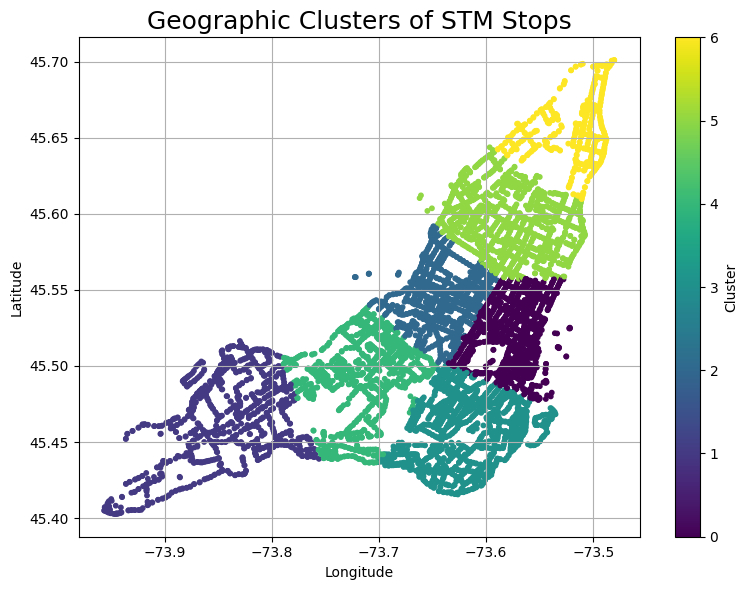

In [65]:
# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(x=stops_df['stop_lon'], y=stops_df['stop_lat'], c=stops_df['cluster'], cmap='viridis', s=10)
plt.title('Geographic Clusters of STM Stops', fontsize=18)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/stop_clusters.png', bbox_inches='tight')
plt.show()

In [66]:
# Merge clusters to dataframe
df = pd.merge(df, stops_df, how='inner', left_on='stop_id', right_on='stop_code')

In [69]:
df.columns

Index(['trip_id', 'vehicle_id', 'vehicle_bearing', 'vehicle_speed',
       'vehicle_in_transit', 'occupancy_status', 'route_id', 'stop_id_x',
       'stop_name_x', 'stop_lat_x', 'stop_lon_x', 'stop_distance',
       'stop_sequence', 'stop_has_alert', 'wheelchair_boarding_x', 'delay',
       'delay_class', 'incident_count', 'incident_nearby', 'temperature',
       'relative_humidity', 'dew_point', 'precipitation', 'pressure',
       'cloud_cover', 'windspeed', 'wind_direction', 'wind_gusts',
       'day_of_week', 'time_of_day_midday', 'time_of_day_morning',
       'time_of_day_night', 'is_weekend', 'is_peak_hour', 'route_type_Day',
       'route_type_Night', 'route_type_Rush Hour High Frequency',
       'sch_rel_Scheduled', 'trip_phase_middle', 'trip_phase_end',
       'stop_group', 'stop_id_y', 'stop_code', 'stop_name_y', 'stop_lat_y',
       'stop_lon_y', 'stop_url', 'location_type', 'parent_station',
       'wheelchair_boarding_y'],
      dtype='object')

### Drop redundant/unnecessary columns


**Columns to drop**

`trip_id`: Identifies a vehicle on a specific day and might cause data leakage.<br>
`vehicle_id`: A unique identifier won't help make predictions.<br>
`route_id`: The route types have been encoded.<br>
`stop_id`, `stop_name`, `stop_lat`, `stop_lon`: The stops are now clustered with K-Means.<br>
`stop_sequence`: The trip phases has been calculated.<br>

In [71]:
df = df.rename(columns={'wheelchair_boarding_x': 'wheelchair_boarding'}).drop([
  	'trip_id',
    'vehicle_id',
  	'route_id',
  	'stop_id_x',
	'stop_name_x',
  	'stop_lat_x',
  	'stop_lon_x',
  	'stop_id_y',
  	'stop_code',
  	'stop_name_y',
  	'stop_lat_y',
	'stop_lon_y',
  	'stop_url',
    'stop_sequence',
  	'location_type',
  	'parent_station',
	'wheelchair_boarding_y'
  ], axis=1)

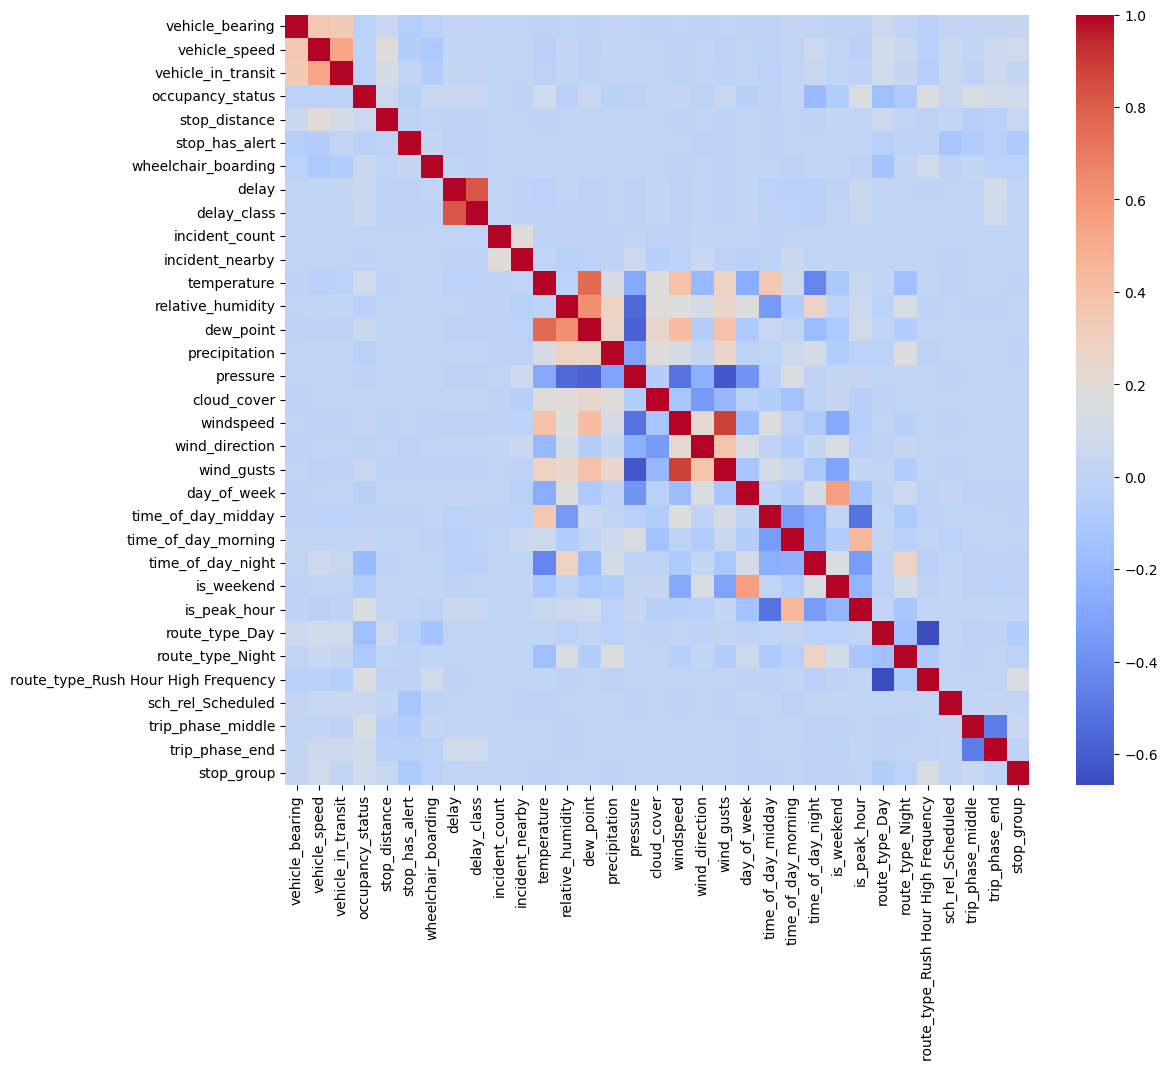

In [73]:
# Look for correlated features
corr_matrix = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

**Correlated features to drop**

`dew_point`: Correlated with temperature and pressure.<br>
`wind_gusts`: It's very correlated with windspeed and pressure.<br>
`route_type_Rush Hour High Frequency`: Strongly related to `route_type_Day`.<br>

In [74]:
df = df.drop(['dew_point', 'wind_gusts', 'route_type_Rush Hour High Frequency'], axis=1)

## Export Data

In [75]:
df.columns

Index(['vehicle_bearing', 'vehicle_speed', 'vehicle_in_transit',
       'occupancy_status', 'stop_distance', 'stop_has_alert',
       'wheelchair_boarding', 'delay', 'delay_class', 'incident_count',
       'incident_nearby', 'temperature', 'relative_humidity', 'precipitation',
       'pressure', 'cloud_cover', 'windspeed', 'wind_direction', 'day_of_week',
       'time_of_day_midday', 'time_of_day_morning', 'time_of_day_night',
       'is_weekend', 'is_peak_hour', 'route_type_Day', 'route_type_Night',
       'sch_rel_Scheduled', 'trip_phase_middle', 'trip_phase_end',
       'stop_group'],
      dtype='object')

In [76]:
# Reorder columns
df = df[[
    	'vehicle_bearing',
    	'vehicle_speed',
    	'vehicle_in_transit',
       	'occupancy_status',
        'route_type_Day',
       	'route_type_Night',
		'stop_group',
		'stop_distance',
    	'stop_has_alert',
		'trip_phase_middle',
    	'trip_phase_end',
      	'wheelchair_boarding',
		'sch_rel_Scheduled',
		'day_of_week',
    	'time_of_day_midday',
    	'time_of_day_morning',
       	'time_of_day_night',
    	'is_weekend',
       	'is_peak_hour',
		'incident_count',
		'incident_nearby',
    	'temperature',
    	'relative_humidity',
    	'precipitation',
    	'pressure',
    	'cloud_cover', 
		'windspeed',
       	'wind_direction',
    	'delay',
       	'delay_class',
]]

In [77]:
# Assert all columns are numeric
assert len(df.columns) == len(df.select_dtypes([np.number]).columns)

In [80]:
# Exports coordinates scaler
with open('../models/scaler_coords.pkl', 'wb') as handle:
	pickle.dump(scaler_coords, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [81]:
# Export dataframe
df.to_parquet('../data/preprocessed.parquet', index=False)

## End